## 多进程

要让Python程序实现多进程（multiprocessing），我们先了解操作系统的相关知识。

Unix/Linux操作系统提供了一个fork()系统调用，它非常特殊。普通的函数调用，调用一次，返回一次，但是fork()调用一次，返回两次，因为操作系统自动把当前进程（称为父进程）复制了一份（称为子进程），然后，分别在父进程和子进程内返回。

子进程永远返回0，而父进程返回子进程的ID。这样做的理由是，一个父进程可以fork出很多子进程，所以，父进程要记下每个子进程的ID，而子进程只需要调用getppid()就可以拿到父进程的ID。

Python的os模块封装了常见的系统调用，其中就包括fork，可以在Python程序中轻松创建子进程：

In [1]:
import os

print('Process (%s) start...' % os.getpid())
# Only works on Unix/Linux/Mac:
pid = os.fork()
if pid == 0:
    print('I am child process (%s) and my parent is %s.' % (os.getpid(), os.getppid()))
else:
    print('I (%s) just created a child process (%s).' % (os.getpid(), pid))

Process (1668) start...


AttributeError: module 'os' has no attribute 'fork'

由于Windows没有fork调用，上面的代码在Windows上无法运行。由于Mac系统是基于BSD（Unix的一种）内核，所以，在Mac下运行是没有问题的

### multiprocessing
如果你打算编写多进程的服务程序，Unix/Linux无疑是正确的选择。由于Windows没有fork调用，难道在Windows上无法用Python编写多进程的程序？

由于Python是跨平台的，自然也应该提供一个跨平台的多进程支持。multiprocessing模块就是跨平台版本的多进程模块。

multiprocessing模块提供了一个Process类来代表一个进程对象，下面的例子演示了启动一个子进程并等待其结束：

* 通过Process实例化1个进程对象，要传入要执行的任务，以及执行任务的时候要传入的参数
* p.start()调用实例化对象的start()
* 如果需要主进程等待子进程运行完毕，主进程才继续运行，那么需要调用p.join()方法

In [4]:
%%writefile multiprocess.py

from multiprocessing import Process
import os

# 子进程要执行的代码
def run_proc(name):
    print('Run child process %s (%s)...' % (name, os.getpid()))

if __name__=='__main__':
    #输出父元素的进程ID
    print('Parent process %s.' % os.getpid())
    
    #执行的任务run_proc，传给target参数，执行的任务需要传递参数，那么需要给args参数传值，传值是元祖
    p = Process(target=run_proc, args=('test',))
    print('Child process will start.')
    p.start()#start方法可以让子进程开始运行
#     p.join()#join等待子进程运行完毕
    print('Child process end.')
    print('整体运行完毕')

Writing multiprocess.py


In [5]:
!python multiprocess.py

Parent process 27632.
Child process will start.
Child process end.
整体运行完毕
Run child process test (2340)...


In [3]:
from multiprocessing import Process
import os

def otherProcess(name):
    print('正在运行子进程：%s，进程的ID是：%s'%(name,os.getpid()))
    
if __name__ == '__main__':
    print('主进程ID是：%s'%(os.getpid()))
    p = Process(target=otherProcess,args=('test',))
    print('子进程即将运行。。。')
    p.start()
    print('这是子进程开始后面的代码')
#     p.join()
    print('子进程已经结束 ')





主进程ID是：9200
子进程即将运行。。。
子进程已经结束 


创建子进程时，只需要传入一个执行函数和函数的参数，创建一个Process实例，用start()方法启动，这样创建进程比fork()还要简单。

join()方法可以等待子进程结束后再继续往下运行，通常用于进程间的同步。

### Pool
如果要启动大量的子进程，可以用进程池的方式批量创建子进程：
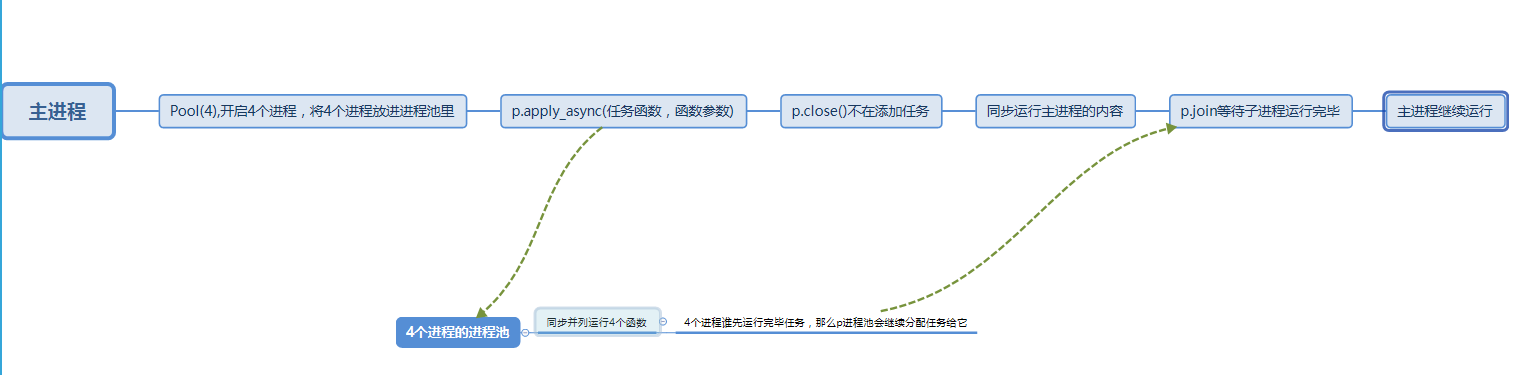

In [12]:
%%writefile poolTask得到子进程运行结果.py
from multiprocessing import Pool
import os,random,time

#任务函数，自定义的，传入什么参数。。。
def poolTask(name):
    print('跑的子进程名字：%s;ID是：%s'%(name,os.getpid()))
    start = time.time()
    time.sleep(random.random()*3)#可能程序是爬某个网页
    end = time.time()
    print('当前%s进程消耗的时间是：%s'%(name,end-start))
    return 'ID是：%s，返回值：%s'%(name,end-start)
    
if __name__ == '__main__':
    print('正在运行父进程')
    p = Pool(4)#进程池，进程池里有4个进程
    reResult = []
    for i in range(10):
        #apply_async异步，不阻塞，子进程的运行不会影响到主进程运行。
        reResult.append(p.apply_async(poolTask,args=('第%s个进程'%i,)))
    print('子进程正在运行当中')
    #不在往进程池里添加任务
    p.close()
    #等待所有的子进程结束
    p.join()
    print('继续执行主程序')
    print('所有内容执行完毕')
    for item in reResult:
        print(item)
        print(item.__dict__)

Overwriting poolTask得到子进程运行结果.py


In [13]:
# !python poolTask.py


### 代码解读：

对Pool对象调用join()方法会等待所有子进程执行完毕，调用join()之前必须先调用close()，调用close()之后就不能继续添加新的Process了。

请注意输出的结果，task 0，1，2，3是立刻执行的，而task 4要等待前面某个task完成后才执行，这是因为Pool的默认大小在我的电脑上是4，因此，最多同时执行4个进程。这是Pool有意设计的限制，并不是操作系统的限制。如果改成：

p = Pool(5)

就可以同时跑5个进程。

由于Pool的默认大小是CPU的核数，如果你不幸拥有8核CPU，你要提交至少9个子进程才能看到上面的等待效果。

### 子进程
很多时候，子进程并不是自身，而是一个外部进程。我们创建了子进程后，还需要控制子进程的输入和输出。

subprocess模块可以让我们非常方便地启动一个子进程，然后控制其输入和输出。

下面的例子演示了如何在Python代码中运行命令nslookup www.python.org，这和命令行直接运行的效果是一样的：

In [6]:
%%writefile sub.py
import subprocess

print('调用起Steam')
r = subprocess.call(['start', 'steam'],shell=True)
print('Exit code:', r)


Overwriting sub.py


In [7]:
!python sub.py

调用起Steam
Exit code: 0


### 进程间通信
Process之间肯定是需要通信的，操作系统提供了很多机制来实现进程间的通信。Python的multiprocessing模块包装了底层的机制，提供了Queue、Pipes等多种方式来交换数据。

我们以Queue为例，在父进程中创建两个子进程，一个往Queue里写数据，一个从Queue里读数据

In [9]:
%%writefile tongxin.py
from multiprocessing import Process, Queue
import os, time, random

# 写数据进程执行的代码:
def write(q):
    print('写入内容的进程ID: %s' % os.getpid())
    for value in ['A', 'B', 'C']:
        print('放入%s到队列里去' % value)
        q.put(value)#往队列里放入数据
        time.sleep(random.random())#调用time.sleep（）休息0-1秒时间

# 读数据进程执行的代码:
def read(q):
    print('读取内容的进程: %s' % os.getpid())
    while True:
        value = q.get(True)#从队列里拿出数据
        print('从队列里获取:%s.' % value)

if __name__=='__main__':
    # 父进程创建Queue，并传给各个子进程：
    q = Queue()#存放数据的地方
    pw = Process(target=write, args=(q,))
    pr = Process(target=read, args=(q,))
    # 启动子进程pw，写入:
    pw.start()
    # 启动子进程pr，读取:
    pr.start()
    # 等待pw结束:
    pw.join()
    # pr进程里是死循环，无法等待其结束，只能强行终止:
    pr.terminate()

Overwriting tongxin.py


In [5]:
!python tongxin.py

Process to write: 2496
Put A to queue...
Put B to queue...
Put C to queue...


In [ ]:
from multiprocessing import Process, Queue
import os, time, random

def read(q):
    value = q.get(True)
    print('读取的内容是：%s'%value)
#     q.put('这是read函数写入的内容')
    
def write(q):
    q.put('我是队列写入的内容')
#     value = q.get(True)
#     print(value)

if __name__ == '__main__':
    q = Queue()
    pw = Process(target=write,args=(q,))
    pr = Process(target=read,args=(q,))
    pw.start()
    pr.start()
    pw.join()
    pr.join()
    print('所有程序运行完毕')


#单线程异步的方式代码
#操作系统能开的进程数是有限。

### Pipes管道

* 管道实例化后会产生两个通道，分别交给两个进程
* 通过send和recv来交互数据，这是一个双向的管道，child和parent可以互相收发

In [2]:
%%writefile pipes.py
from multiprocessing import Process, Pipe

def f(conn):
#     conn.send([42, None, 'hello'])
#     conn.send([43,32])
    print(conn.recv())
    conn.close()

if __name__ == '__main__':
    #Pipe实例化返回一个元祖对象，分别给到主进程端口，子进程端口
    parent_conn, child_conn = Pipe()
    #其中1个端口对象作为参数传入至进程
    p = Process(target=f, args=(child_conn,))
    p.start()
    #数据传递，也是以队列的形式进行传递，先发送先接受。
#     print(parent_conn.recv())  # prints "[42, None, 'hello']"
#     print(parent_conn.recv())
    parent_conn.send('主进程发送给子进程的数据')
    p.join()

Overwriting pipes.py


### Managers经理/代理

* 以代理的方式在进程间共享字典或列表形式的数据

In [5]:
%%writefile daili.py
from multiprocessing import Process, Manager
import os
#进程要运行的任务
def f(d, l,normalList):
    d[1] = '1'
    d['2'] = 2
    d[0.25] = None
    l.append(os.getpid())
    normalList.append(os.getpid())
    print(l)
    print(normalList)

if __name__ == '__main__':
    with Manager() as manager:
        d = manager.dict()#生成一个字典，在多个进程间共享和传递

        l = manager.list(range(5))#生成一个列表含5个初始值，在多个进程间传递和共享
        p_list = []#专门放置进程的列表
        normalList = []
        for i in range(10):
            p = Process(target=f, args=(d, l,normalList))
            p.start()
            p_list.append(p)
        for res in p_list:
            res.join()

        print(d)
        print(l)

Overwriting daili.py


In [27]:
%%writefile download.py
from multiprocessing import Pool
import requests
import re
import random
class dImg():
    def __init__(self):
        self.count = 0
        pass
    def run(self):
        self.userSearch = input('请输入你想要下载的图片:')
        self.userNum = int(input('你想要下载多少页面图片:'))
        self.download()
    def processRun(self):
        self.userSearch = input('请输入你想要下载的图片:')
        self.userNum = int(input('你想要下载多少页面图片:'))
        self.multiDownPage()
    def download(self):
        for item in range(self.userNum):
            self.downloadPage(item)
    def downloadPage(self,item):
        item = item + 1
        res = requests.get('https://pixabay.com/zh/photos/?q={}&pagi={}'.format(self.userSearch,item))
        pattern = re.compile('<div class="item".*?<img.*?src="(http.*?)".*?title="(.*?)">',re.S)
        result = re.findall(pattern,res.text)
        print(res.text)
        for item in result:
            imgContent = requests.get(item[0])
            ranNum = random.randint(0,100000000)
            with open('./image/{}.jpg'.format(ranNum),'wb') as f:
                f.write(imgContent.content)
                print('已下载完：%s图'%ranNum)
                self.count = self.count + 1
    def multiDownPage(self):
        p = Pool(self.userNum)
        for i in range(self.userNum):
            p.apply_async(self.downloadPage, args=(i,))
        p.close()
        p.join()
        print('所有图片下载完毕')
        
        
                
if __name__ == '__main__':
    a = dImg()
    # a.run()
    a.processRun()

Overwriting download.py


In [14]:
%%writefile testDownload.py
from multiprocessing import Pool
import requests
import re
import random

def downloadTask(page):
    url = 'https://pixabay.com/zh/photos/?q={}&pagi={}'.format('风景',page)
    print(url)
    res = requests.get(url)
    print(res.text)
    pattern = re.compile('<div class="item".*?<img.*?src="(h.*?)"',re.S)
    print(pattern)
    result = re.findall(pattern,res.text)
    print(result)
    for item in result:
            imgContent = requests.get(item)
            ranNum = random.randint(0,100000000)
            with open('./image/{}.jpg'.format(ranNum),'wb') as f:
                f.write(imgContent.content)
                print('已下载完：%s图'%ranNum)


                
if __name__=='__main__':
    p = Pool(10)
    for i in range(10):
#         downloadTask(i)
        p.apply_async(downloadTask,args=(i+1,))
    p.close()
    p.join()
    print('图片下载完毕')
        

    
# downloadTask()


Overwriting testDownload.py


在Unix/Linux下，multiprocessing模块封装了fork()调用，使我们不需要关注fork()的细节。由于Windows没有fork调用，因此，multiprocessing需要“模拟”出fork的效果，父进程所有Python对象都必须通过pickle序列化再传到子进程去，所有，如果multiprocessing在Windows下调用失败了，要先考虑是不是pickle失败了。

### 小结
在Unix/Linux下，可以使用fork()调用实现多进程。

要实现跨平台的多进程，可以使用multiprocessing模块。

进程间通信是通过Queue、Pipes等实现的。